In [1]:
# import dependencies

import re
import os
import csv
import pandas as pd
from dotenv import load_dotenv
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Process 2024 Social Media Post Data

In [2]:
# Read in 2024 CSV file
df_2024 = pd.read_csv("../Source_Data/posts_2024.csv",)

# Display sample data
df_2024.head(5)

,author,title,description,url,source,image,category,language,country,published_at,sentiment,sentiment_label
0,Mark Hines,A recent Supreme Court ruling should please th...,(ThyBlackMan.com) While much of the U.S. was f...,https://thyblackman.com/2024/07/21/a-recent-su...,thyblackman,NaN,general,en,us,2024-07-22T01:14:36+00:00,0.000000,neutral
1,Anthony Garreffa,President Trump: if Taiwan doesn't pay for US ...,"President Trump says under his administration,...",https://www.tweaktown.com/news/99447/president...,tweaktown,https://www.tweaktown.com/images/news/9/9/9944...,general,en,us,2024-07-22T01:07:53+00:00,0.000000,neutral
2,NaN,Gun enthusiast reveals extraordinary new detai...,Gunman Thomas Matthew Crooks and veteran Bill ...,https://www.dailymail.co.uk/news/article-13657...,dailymail,https://i.dailymail.co.uk/1s/2024/07/22/01/876...,general,en,us,2024-07-22T01:04:34+00:00,-0.176768,negative
3,Andrew Prokop,It was not undemocratic for the Democrats to d...,"Then-Speaker of the House Nancy Pelosi (D-CA),...",https://www.vox.com/politics/362062/biden-drop...,VOX,NaN,general,en,gi,2024-07-22T00:59:29+00:00,0.000000,neutral
4,NaN,WATCH: Would Donald Trump and Kamala Harris de...,"Now that Biden is out of the race, Chairperson...",https://abcnews.go.com/Politics/video/donald-t...,ABC News,https://s.abcnews.com/images/Politics/240721_a...,general,en,us,2024-07-22T00:59:18+00:00,0.000000,neutral


In [3]:
# Filter rows where 'country' contains 'us'
df_2024_filtered = df_2024[df_2024['country'].str.contains('us', case=False, na=False)]

In [5]:
# Restrict dataframe to columns of interest

# Define the columns to keep
columns_to_keep = ['author', 'description', 'published_at', 'sentiment', 'sentiment_label']

# Drop all columns except the specified ones
posts_2024_df = df_2024_filtered[columns_to_keep]

# Convert 'text' column to string to ensure uniform processing
posts_2024_df['description'] = posts_2024_df['description'].astype(str)

# View dataframe
posts_2024_df.head()

C:\Users\STEFF\AppData\Local\Temp\ipykernel_32612\3079809048.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts_2024_df['description'] = posts_2024_df['description'].astype(str)


,author,description,published_at,sentiment,sentiment_label
0,Mark Hines,(ThyBlackMan.com) While much of the U.S. was f...,2024-07-22T01:14:36+00:00,0.000000,neutral
1,Anthony Garreffa,"President Trump says under his administration,...",2024-07-22T01:07:53+00:00,0.000000,neutral
2,NaN,Gunman Thomas Matthew Crooks and veteran Bill ...,2024-07-22T01:04:34+00:00,-0.176768,negative
4,NaN,"Now that Biden is out of the race, Chairperson...",2024-07-22T00:59:18+00:00,0.000000,neutral
5,"Roxana Popescu, David Garrick",Elected officials from San Diego County reacte...,2024-07-22T00:54:26+00:00,0.000000,neutral


In [6]:
# Rename columns
posts_2024_df.rename(columns={
    'author': 'handle',
    'description': 'text',
    'published_at': 'time'
}, inplace=True)

# Add a unique identifier column
posts_2024_df['id'] = posts_2024_df.index

# Verify the result
posts_2024_df.head()

C:\Users\STEFF\AppData\Local\Temp\ipykernel_32612\2307457903.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts_2024_df.rename(columns={
C:\Users\STEFF\AppData\Local\Temp\ipykernel_32612\2307457903.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts_2024_df['id'] = posts_2024_df.index


,handle,text,time,sentiment,sentiment_label,id
0,Mark Hines,(ThyBlackMan.com) While much of the U.S. was f...,2024-07-22T01:14:36+00:00,0.000000,neutral,0
1,Anthony Garreffa,"President Trump says under his administration,...",2024-07-22T01:07:53+00:00,0.000000,neutral,1
2,NaN,Gunman Thomas Matthew Crooks and veteran Bill ...,2024-07-22T01:04:34+00:00,-0.176768,negative,2
4,NaN,"Now that Biden is out of the race, Chairperson...",2024-07-22T00:59:18+00:00,0.000000,neutral,4
5,"Roxana Popescu, David Garrick",Elected officials from San Diego County reacte...,2024-07-22T00:54:26+00:00,0.000000,neutral,5


In [8]:
posts_2024_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 0 to 29
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   handle           15 non-null     object 
 1   text             24 non-null     object 
 2   time             24 non-null     object 
 3   sentiment        24 non-null     float64
 4   sentiment_label  24 non-null     object 
 5   id               24 non-null     int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 1.3+ KB


In [9]:
sentiments = []

for comment in posts_2024_df['text']:
    try:
        # Ensure comment is a string
        if not isinstance(comment, str):
            raise ValueError("Comment is not a string")
            
        results = analyzer.polarity_scores(comment)
               
        sentiments.append({
            'Compound': results['compound'],
            'Positive': results['pos'],
            'Negative': results['neg'],
            'Neutral': results['neu'],
            'text': comment,
        })
    
    except Exception as e:
        print(f"Error processing comment: {e}")
        continue
    
sm24 = pd.DataFrame(sentiments)
sm24.head()

,Compound,Positive,Negative,Neutral,text
0,0.9713,0.247,0.023,0.729,(ThyBlackMan.com) While much of the U.S. was f...
1,-0.2732,0.047,0.112,0.841,"President Trump says under his administration,..."
2,0.0000,0.000,0.000,1.000,Gunman Thomas Matthew Crooks and veteran Bill ...
3,0.4588,0.107,0.000,0.893,"Now that Biden is out of the race, Chairperson..."
4,0.7351,0.177,0.000,0.823,Elected officials from San Diego County reacte...


In [10]:
#summary statistics sm16
sm24_stats_df = sm24.describe()
sm24_stats_df

,Compound,Positive,Negative,Neutral
count,24.000000,24.000000,24.000000,24.000000
mean,0.253396,0.108875,0.030167,0.860875
std,0.480461,0.103318,0.047987,0.096065
min,-0.761500,0.000000,0.000000,0.686000
25%,0.000000,0.018750,0.000000,0.813750
50%,0.350600,0.090500,0.000000,0.871000
75%,0.564525,0.177500,0.052500,0.916250
max,0.971300,0.314000,0.158000,1.000000


In [11]:
# Save the 2016 summary stats to a CSV file
sm24_stats_df.to_csv('CSV_Output_Sentiment/stats_2024_df.csv', index=False)

In [12]:
# Tokenize the text and calculate sentiment for each token
def get_token_sentiments_2024(text):
    tokens24 = word_tokenize(text.lower())  # Tokenize and convert to lower case
    token_sentiments_2024 = {}
    
    for token in tokens24:
        if token.isalpha():  # Consider only alphabetic tokens
            # Analyze sentiment for each token in the context of the whole text
            sentiment_2024 = analyzer.polarity_scores(token)
            token_sentiments_2024[token] = sentiment_2024['compound']
    
    return token_sentiments_2024

In [13]:
# Apply the function to each row and expand the results into a DataFrame
def process_text_2024(text):
    token_sentiments_2024 = get_token_sentiments_2024(text)
    return token_sentiments_2024

In [14]:
# Apply the function to the 'text' column
sm24['token_sentiments_2024'] = sm24['text'].apply(process_text_2024)

# Expand token sentiments into separate columns
tokens_2024_df = pd.json_normalize(sm24['token_sentiments_2024'])

# Rename columns in tokens_df to avoid overlap with original sm16 columns
tokens_2024_df.columns = [f'token_{col}' for col in tokens_2024_df.columns]

sm24 = sm24.drop(columns=['token_sentiments_2024']).join(tokens_2024_df)

# Analyze and visualize token sentiment
sm24.head()

,Compound,Positive,Negative,Neutral,text,token_while,token_much,token_of,token_the,token_was,...,token_did,token_north,token_carolina,token_gov,token_roy,token_rumored,token_short,token_list,token_possible,token_mates
0,0.9713,0.247,0.023,0.729,(ThyBlackMan.com) While much of the U.S. was f...,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.2732,0.047,0.112,0.841,"President Trump says under his administration,...",NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0000,0.000,0.000,1.000,Gunman Thomas Matthew Crooks and veteran Bill ...,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.4588,0.107,0.000,0.893,"Now that Biden is out of the race, Chairperson...",NaN,NaN,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.7351,0.177,0.000,0.823,Elected officials from San Diego County reacte...,0.0,NaN,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Average sentiment score per token
average_sentiments_2024 = tokens_2024_df.mean().sort_values(ascending=False)
print("Average sentiment scores per token:")
print(average_sentiments_2024)

Average sentiment scores per token:
token_honored       0.5859
token_win           0.5859
token_celebrated    0.5719
token_supreme       0.5574
token_winning       0.5267
                     ...  
token_mocking      -0.4019
token_ridiculing   -0.4215
token_attacks      -0.4404
token_attacking    -0.4588
token_poor         -0.4767
Length: 454, dtype: float64


In [16]:
# Function to determine candidate based on text
def determine_candidate(text):
    text = text.lower()  # Convert text to lower case for case-insensitive comparison
    republican_keywords = ['trump', 'donald']
    democrat_keywords = ['kamala', 'harris']
    
    if any(keyword in text for keyword in democrat_keywords):
        return 'democrat'
    elif any(keyword in text for keyword in republican_keywords):
        return 'republican'
    else:
        return 'unknown'

In [17]:
# Add candidate column
posts_2024_df['candidate'] = posts_2024_df['text'].apply(determine_candidate)
posts_2024_df.head()

C:\Users\STEFF\AppData\Local\Temp\ipykernel_32612\3050881208.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts_2024_df['candidate'] = posts_2024_df['text'].apply(determine_candidate)


,handle,text,time,sentiment,sentiment_label,id,candidate
0,Mark Hines,(ThyBlackMan.com) While much of the U.S. was f...,2024-07-22T01:14:36+00:00,0.000000,neutral,0,republican
1,Anthony Garreffa,"President Trump says under his administration,...",2024-07-22T01:07:53+00:00,0.000000,neutral,1,republican
2,NaN,Gunman Thomas Matthew Crooks and veteran Bill ...,2024-07-22T01:04:34+00:00,-0.176768,negative,2,unknown
4,NaN,"Now that Biden is out of the race, Chairperson...",2024-07-22T00:59:18+00:00,0.000000,neutral,4,democrat
5,"Roxana Popescu, David Garrick",Elected officials from San Diego County reacte...,2024-07-22T00:54:26+00:00,0.000000,neutral,5,republican


In [20]:
# Filter out rows where candidate is 'unknown'
posts_2024_df = posts_2024_df[posts_2024_df['candidate'] != 'unknown']

# Verify the result
posts_2024_df.head()

,handle,text,time,sentiment,sentiment_label,id,candidate
0,Mark Hines,(ThyBlackMan.com) While much of the U.S. was f...,2024-07-22T01:14:36+00:00,0.000000,neutral,0,republican
1,Anthony Garreffa,"President Trump says under his administration,...",2024-07-22T01:07:53+00:00,0.000000,neutral,1,republican
4,NaN,"Now that Biden is out of the race, Chairperson...",2024-07-22T00:59:18+00:00,0.000000,neutral,4,democrat
5,"Roxana Popescu, David Garrick",Elected officials from San Diego County reacte...,2024-07-22T00:54:26+00:00,0.000000,neutral,5,republican
7,NaN,(marketscreener.com) The dollar eased on Monda...,2024-07-22T00:42:45+00:00,0.166667,positive,7,republican


In [21]:
# Count the number of 'Unknown' entries in the 'candidate' column
unknown_count = posts_2024_df['candidate'].value_counts().get('unknown', 0)

print(f"Number of 'Unknown' entries: {unknown_count}")

Number of 'Unknown' entries: 0


In [22]:
# Merge sm24 with posts_2024_df on the 'text' column to add 'candidate'
sm24_with_candidates = pd.merge(sm24, posts_2024_df[['text', 'candidate']], on='text', how='left')

# View dataframe
sm24_with_candidates.head()

,Compound,Positive,Negative,Neutral,text,token_while,token_much,token_of,token_the,token_was,...,token_north,token_carolina,token_gov,token_roy,token_rumored,token_short,token_list,token_possible,token_mates,candidate
0,0.9713,0.247,0.023,0.729,(ThyBlackMan.com) While much of the U.S. was f...,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,republican
1,-0.2732,0.047,0.112,0.841,"President Trump says under his administration,...",NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,republican
2,0.0000,0.000,0.000,1.000,Gunman Thomas Matthew Crooks and veteran Bill ...,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.4588,0.107,0.000,0.893,"Now that Biden is out of the race, Chairperson...",NaN,NaN,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,democrat
4,0.7351,0.177,0.000,0.823,Elected officials from San Diego County reacte...,0.0,NaN,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,republican


In [24]:
# Save the 2016 sentiment and cnadidate by post to a CSV file
sm24_with_candidates.to_csv('CSV_Output_Sentiment/sent_and_cand_by_post_2024.csv', index=False)

In [26]:
# Identify all token columns
token_columns = [col for col in sm24_with_candidates.columns if col.startswith('token_')]

# Ensure that the value name does not match any existing column names
# Checking for potential conflicts
existing_columns = set(sm24_with_candidates.columns)
unique_value_name = 'token_count' if 'token_count' not in existing_columns else 'token_count_unique'

# Reshape the DataFrame from wide to long format for tokens
tokens_long_df = sm24_with_candidates.melt(
    id_vars=['text', 'candidate'], 
    value_vars=token_columns,
    var_name='token',
    value_name=unique_value_name
)

# Filter out rows where token_count is 0
tokens_long_df = tokens_long_df[tokens_long_df[unique_value_name] > 0]

# Melt sentiment columns to long format
sentiment_columns = ['Compound', 'Positive', 'Negative', 'Neutral']
sentiments_long_df = sm24_with_candidates.melt(
    id_vars=['text', 'candidate'],
    value_vars=sentiment_columns,
    var_name='sentiment_type',
    value_name='sentiment_value'
)

# Merge token presence with sentiment values on 'text' and 'candidate'
merged_df = tokens_long_df.merge(sentiments_long_df, on=['text', 'candidate'])

# Aggregate sentiment values by candidate and token
token_sentiments_2024 = merged_df.groupby(['candidate', 'token']).agg({
    'sentiment_value': 'mean',
    unique_value_name: 'sum'
}).reset_index()

# Verify the result
token_sentiments_2024.head()

,candidate,token,sentiment_value,token_count
0,democrat,token_accepted,0.488800,1.0928
1,democrat,token_care,0.373475,1.9756
2,democrat,token_clear,0.389350,1.5272
3,democrat,token_endorsed,0.347455,5.0000
4,democrat,token_endorsement,0.488800,1.2728


In [28]:
# Aggregate sentiment scores by candidate

# Calculate weighted average sentiment score for each candidate
# This step uses the 'sentiment_value' and 'token_count_unique' columns
candidate_sentiments_24 = token_sentiments_2024.groupby('candidate').apply(
    lambda df: (df['sentiment_value'] * df['token_count']).sum() / df['token_count'].sum()
).reset_index(name='average_sentiment')

# Display the aggregated sentiment scores
print("Average sentiment scores by candidate:")
print(candidate_sentiments_24)

Average sentiment scores by candidate:
    candidate  average_sentiment
0    democrat           0.378815
1  republican           0.451690


In [30]:
# Combine sentiment scores with other features

# Merge candidate sentiments with posts_2024_df
# Make sure to use the 'candidate' column for merging
sent_2024_df = pd.merge(posts_2024_df, candidate_sentiments_24, on='candidate', how='left')

# Display the final DataFrame with the required columns
sent_2024_df = sent_2024_df[['id', 'text', 'time', 'candidate', 'average_sentiment']]
sent_2024_df.head()

,id,text,time,candidate,average_sentiment
0,0,(ThyBlackMan.com) While much of the U.S. was f...,2024-07-22T01:14:36+00:00,republican,0.451690
1,1,"President Trump says under his administration,...",2024-07-22T01:07:53+00:00,republican,0.451690
2,4,"Now that Biden is out of the race, Chairperson...",2024-07-22T00:59:18+00:00,democrat,0.378815
3,5,Elected officials from San Diego County reacte...,2024-07-22T00:54:26+00:00,republican,0.451690
4,7,(marketscreener.com) The dollar eased on Monda...,2024-07-22T00:42:45+00:00,republican,0.451690


In [31]:
# Edit the time column to display only the year

# Ensure the 'time' column is in datetime format
sent_2024_df['time'] = pd.to_datetime(sent_2024_df['time'], errors='coerce')

# Extract the year from the datetime column and update the 'time' column
sent_2024_df['time'] = sent_2024_df['time'].dt.year

# Display the modified DataFrame
sent_2024_df.head()

,id,text,time,candidate,average_sentiment
0,0,(ThyBlackMan.com) While much of the U.S. was f...,2024,republican,0.451690
1,1,"President Trump says under his administration,...",2024,republican,0.451690
2,4,"Now that Biden is out of the race, Chairperson...",2024,democrat,0.378815
3,5,Elected officials from San Diego County reacte...,2024,republican,0.451690
4,7,(marketscreener.com) The dollar eased on Monda...,2024,republican,0.451690


In [32]:
# Save the final 2016 dataFrame for use in PostGres to a CSV file
sent_2024_df.to_csv('CSV_Output_Sentiment/sent_info_for_db_2024.csv', index=False)

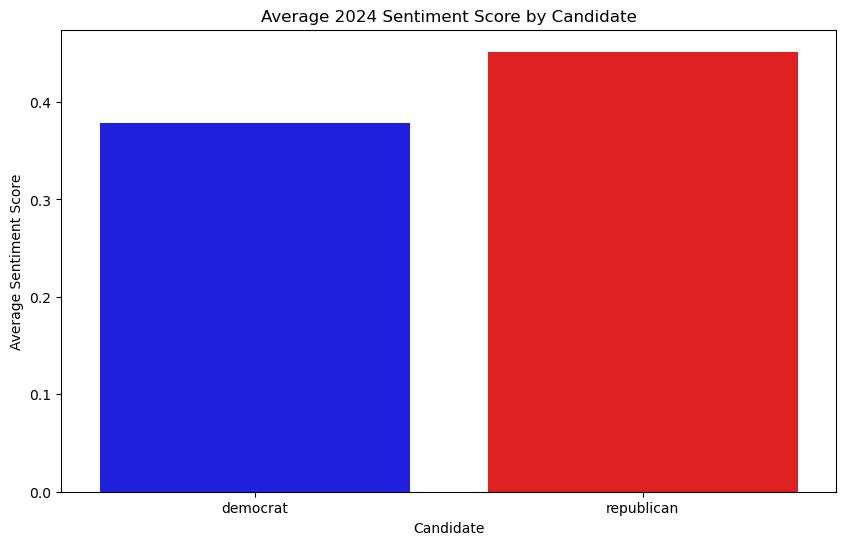

In [34]:
# Plot average sentiment scores for each candidate

# Define color palette to match the colleague's visual
color_palette = {'democrat': 'blue', 'republican': 'red'}

# Create a seaborn bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='candidate', y='average_sentiment', data=candidate_sentiments_24, palette=color_palette)

# Add labels and title
plt.xlabel('Candidate')
plt.ylabel('Average Sentiment Score')
plt.title('Average 2024 Sentiment Score by Candidate')
plt.savefig('../Visualizations/avg_sent_by_cand_2024.png')

# Show the plot
plt.show()

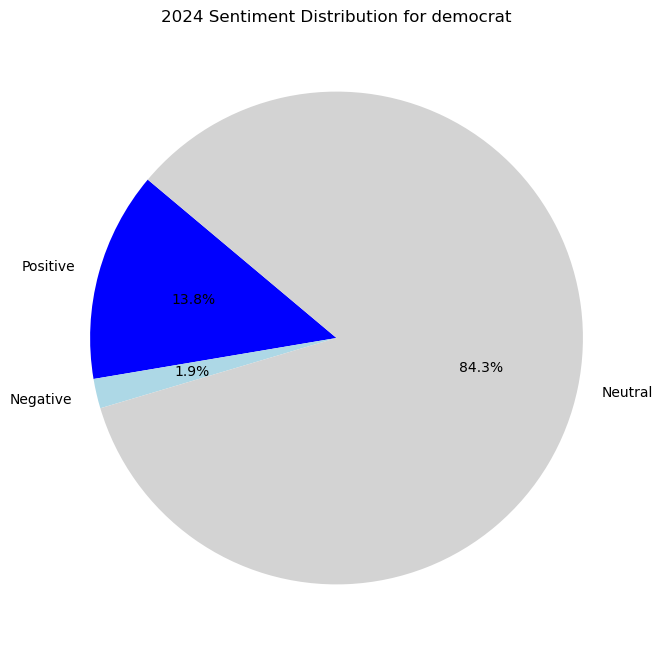

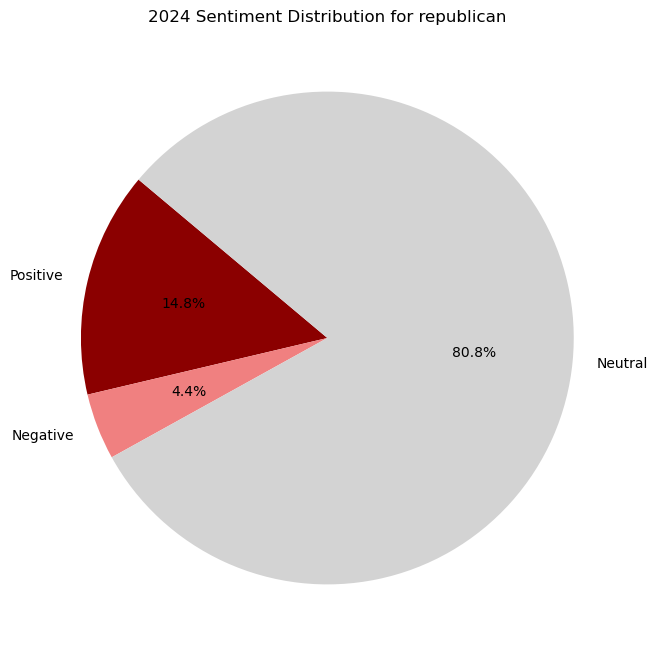

In [35]:
# Display positive, negative, and neutral sentiment scores by candidate

# Aggregate sentiment scores by candidate
sentiment_summary = sm24_with_candidates.groupby('candidate')[['Positive', 'Negative', 'Neutral']].sum().reset_index()

# Define color palette for sentiments
color_palettes = {
    'democrat': {
        'Positive': 'blue',  # Replace 'strongblue' with actual color code
        'Negative': 'lightblue',   # Replace 'palerblue' with actual color code
        'Neutral': 'lightgrey'
    },
    'republican': {
        'Positive': 'darkred',     # Strong red
        'Negative': 'lightcoral',  # Pale red
        'Neutral': 'lightgrey'
    }
}

# Define a function to plot a pie chart for a given candidate
def plot_pie_chart(candidate, positive, negative, neutral):
    sentiments = [positive, negative, neutral]
    labels = ['Positive', 'Negative', 'Neutral']
    colors = color_palettes.get(candidate, {
        'Positive': 'grey',
        'Negative': 'grey',
        'Neutral': 'grey'
    }).values()
    
    plt.figure(figsize=(8, 8))
    plt.pie(sentiments, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title(f'2024 Sentiment Distribution for {candidate}')
    plt.savefig('../Visualizations/pos_neg_neut_by_party_2024.png')
    plt.show()

# Plot pie charts for each candidate
for index, row in sentiment_summary.iterrows():
    candidate = row['candidate']
    positive = row['Positive']
    negative = row['Negative']
    neutral = row['Neutral']
    plot_pie_chart(candidate, positive, negative, neutral)
